In [1]:
#Followed the following github link 
# https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/18_transfer_learning/cnn_transfer_learning.ipynb
# downgrad tensorflow-estimator to 2.3.0 which is in the dependency lis of tensorflow_hub
# tensorflow version 2.3.1 was used

# Download the dataset from following link

# https://gtvault-my.sharepoint.com/:u:/g/personal/madnaan3_gatech_edu/EUmIVdH7SL9FsYAe-ZFY20YBPMooeOEI0ZlXpOgDQgKAsw?e=5sgSpu

# extract the flower_photos folder in the same folder as transfer_learning_cfir_updated.ipynb 


import numpy as np
import cv2
import PIL
import PIL.Image as Image
import os
import random
import matplotlib.pylab as plt

import tensorflow as tf
from numpy import asarray
import pickle
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
import tensorflow_hub as hub

# Load Pretrained model

In [13]:
IMAGE_SHAPE = (224, 224)

# classifier1 = tf.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
# ])
classifier = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=True)
#classifier.set_weights(classifier1.get_weights())

14540800/14536120 [==============================] - 3s 0us/step


ValueError: Layer weight shape (3, 3, 3, 32) not compatible with provided weight shape (3, 3, 960, 1)

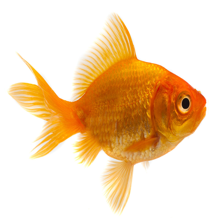

In [3]:
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [4]:

gold_fish = np.array(gold_fish)/255.0
gold_fish.shape
gold_fish[np.newaxis, ...]
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1000)

In [5]:
predicted_label_index = np.argmax(result)
predicted_label_index

1

In [6]:
tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [7]:
image_labels[predicted_label_index]

'tench'

# Load dataset from local folder

In [33]:
labels=['roses', 'daisy','dandelion','sunflowers', 'tulips']
types_of_data=len(labels)
data_dir =pathlib.Path('./flower_photos/train')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


0


In [34]:
train_data_x=np.zeros((1,IMAGE_SHAPE[0],IMAGE_SHAPE[1],3))
train_data_y=np.zeros((1,1))

for j in range(types_of_data):
    data = list(data_dir.glob(labels[j]+'/*'))
    yi=np.full((len(data),1),j)

    for i in range(len(data)):
        resized_img = cv2.resize(asarray(PIL.Image.open(str(data[i]))),(IMAGE_SHAPE[0],IMAGE_SHAPE[1]))
        resized_img=np.reshape(resized_img,(1,IMAGE_SHAPE[0],IMAGE_SHAPE[1],3))
        train_data_x=np.append(train_data_x, resized_img, axis=0)

    train_data_y=np.append(train_data_y, yi, axis=0)
    
    


In [35]:
train_x=np.delete(train_data_x,0,0)
train_y=np.delete(train_data_y,0,0)
sorting= np.arange(len(train_y)-1)
np.random.shuffle(sorting)
train_x_final=np.zeros((len(train_y),IMAGE_SHAPE[0],IMAGE_SHAPE[1],3))
train_y_final=np.zeros((len(train_y),1))

for i in range(len(train_y)-1):
    train_x_final[i]=train_x[sorting[i]]
    train_y_final[i]=train_y[sorting[i]]
    
print(train_x_final.shape)
print(train_y_final.shape)

(0, 224, 224, 3)
(0, 1)


In [36]:
data_dir =pathlib.Path('./flower_photos/test')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

0


In [37]:
test_data_x=np.zeros((1,IMAGE_SHAPE[0],IMAGE_SHAPE[1],3))
test_data_y=np.zeros((1,1))

for j in range(types_of_data):
    data = list(data_dir.glob(labels[j]+'/*'))
    yi=np.full((len(data),1),j)

    for i in range(len(data)):
        resized_img = cv2.resize(asarray(PIL.Image.open(str(data[i]))),(IMAGE_SHAPE[0],IMAGE_SHAPE[1]))
        resized_img=np.reshape(resized_img,(1,IMAGE_SHAPE[0],IMAGE_SHAPE[1],3))
        test_data_x=np.append(test_data_x, resized_img, axis=0)

    test_data_y=np.append(test_data_y, yi, axis=0)
    

In [38]:
test_x=np.delete(test_data_x,0,0)
test_y=np.delete(test_data_y,0,0)
sorting= np.arange(len(test_y)-1)
np.random.shuffle(sorting)
test_x_final=np.zeros((len(test_y),IMAGE_SHAPE[0],IMAGE_SHAPE[1],3))
test_y_final=np.zeros((len(test_y),1))

for i in range(len(test_y)-1):
    test_x_final[i]=test_x[sorting[i]]
    test_y_final[i]=test_y[sorting[i]]
    
print(test_x_final.shape)
print(test_y_final.shape)

(0, 224, 224, 3)
(0, 1)


In [39]:
Xtrain1 = np.array(train_x_final).astype('float16',casting='same_kind')
ytrain1 = np.array(train_y_final).astype('float16',casting='same_kind')
Xtest1 = np.array(test_x_final).astype('float16',casting='same_kind')
ytest1 = np.array(test_y_final).astype('float16',casting='same_kind')

In [40]:
X_train_scaled = Xtrain1 / 255
X_test_scaled = Xtest1 / 255
print(Xtest1.shape)

(0, 224, 224, 3)


In [41]:
pretrained_model_without_top_layer = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), include_top=False)
pretrained_model_without_top_layer.trainable = False

In [42]:
num_of_class = types_of_data

# generates transfer learning model
input = tf.keras.layers.Input((224, 224, 3))
mobile_out = pretrained_model_without_top_layer(input)
flat_out = tf.keras.layers.Flatten()(mobile_out)
output =  tf.keras.layers.Dense(num_of_class)(flat_out)
model = tf.keras.Model(inputs = input, outputs = output)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [43]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

print(X_test_scaled.shape)
model.fit(X_train_scaled, ytrain1, epochs=5)

(0, 224, 224, 3)
Epoch 1/5


ValueError: Expect x to be a non-empty array or dataset.

In [ ]:
model.evaluate(X_test_scaled,ytest1)

In [ ]:
rs = Image.open("rose.jpg").resize(IMAGE_SHAPE)
rs

In [ ]:
rs = np.array(rs)/255.0
rs.shape
rs[np.newaxis, ...]
result = model.predict(rs[np.newaxis, ...])
result.shape

In [ ]:
predicted_label_index = np.argmax(result)
labels[predicted_label_index]

# Load Cifar10 dataset

In [14]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
X_train.shape

(50000, 32, 32, 3)

In [15]:
len(X_test)

10000

In [16]:
y_train.shape

(50000, 1)

In [17]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [18]:
y_train = y_train.reshape(-1,)
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [19]:
y_test = y_test.reshape(-1,)

In [20]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [21]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

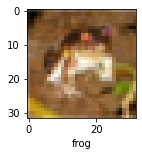

In [22]:
plot_sample(X_train, y_train, 0)

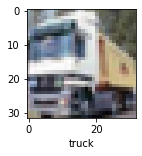

In [23]:
plot_sample(X_train, y_train, 1)

# Crop Cifar10 dataset to 10000 train image and 1000 test image

In [24]:
sample_indices_train = np.random.choice(len(X_train), 10000, replace = False)
sample_test_indices = np.random.choice(len(X_test), 1000, replace = False)
X_train=X_train[sample_indices_train]
y_train=y_train[sample_indices_train]
X_test=X_test[sample_test_indices]
y_test=y_test[sample_test_indices]

In [25]:
Xtrain, ytrain = [], []

for i in range(len(X_train)):
    img = X_train[i]
    resized_img = cv2.resize(img,(224,224))
    Xtrain.append(resized_img)
    ytrain.append(y_train[i])

In [26]:
Xtest, ytest = [], []

for i in range(len(X_test)):
    img = X_test[i]
    resized_img = cv2.resize(img,(224,224))
    Xtest.append(resized_img)
    ytest.append(y_test[i])

In [27]:
Xtrain1 = np.array(Xtrain).astype('float16',casting='same_kind')
ytrain1 = np.array(ytrain).astype('float16',casting='same_kind')
Xtest1 = np.array(Xtest).astype('float16',casting='same_kind')
ytest1 = np.array(ytest).astype('float16',casting='same_kind')

In [28]:
X_train_scaled = Xtrain1 / 255
X_test_scaled = Xtest1 / 255

In [29]:

pretrained_model_without_top_layer = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
pretrained_model_without_top_layer.trainable = False

In [30]:
num_of_class = 10

# generates transfer learning model
input = tf.keras.layers.Input((224, 224, 3))
mobile_out = pretrained_model_without_top_layer(input)
flat_out = tf.keras.layers.Flatten()(mobile_out)
output =  tf.keras.layers.Dense(num_of_class)(flat_out)
model = tf.keras.Model(inputs = input, outputs = output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                627210    
Total params: 2,885,194
Trainable params: 627,210
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:

model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])
print(model.output.shape)
print(X_train_scaled.shape)
print(ytrain1.shape)
model.fit(X_train_scaled, ytrain1, epochs=3)

(None, 10)
(10000, 224, 224, 3)
(10000,)
Epoch 1/3
168/313 [===============>..............] - ETA: 1:02 - loss: 4.6552 - acc: 0.6512

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test_scaled,ytest1)

32/32 [==============================] - 11s 340ms/step - loss: 0.6290 - acc: 0.7840


[0.6289803981781006, 0.7839999794960022]

In [ ]:
horse = Image.open("horse.jpg").resize(IMAGE_SHAPE)
horse

In [ ]:
horse = np.array(horse)/255.0
horse.shape
horse[np.newaxis, ...]
result = model.predict(horse[np.newaxis, ...])
result.shape

In [ ]:
predicted_label_index = np.argmax(result)
classes[predicted_label_index]

In [ ]:

#[l.shape for l in model.get_weights()]
model.save("trained_model.h5")